In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

Tensorflow version is  1.13.1


Using TensorFlow backend.


## setup training

In [2]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir('dataset\\v3')
data_frames = make_dataframe('dataset\\v3', validation_percentage = 0.13, test_percentage=0.17)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    ##zca_whitening=True,
    rotation_range=15.
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Total size:  501
Training set size:  351
Validation set size:  66
Test set size:  84
Total size:  410
Training set size:  288
Validation set size:  54
Test set size:  68
Total size:  997
Training set size:  699
Validation set size:  130
Test set size:  168
Total size:  527
Training set size:  370
Validation set size:  69
Test set size:  88


In [3]:
# make generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_frames[0],
    x_col='path',
    y_col='label',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = batch_size)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_frames[1],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_frames[2],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

Found 1708 validated image filenames belonging to 4 classes.
Found 319 validated image filenames belonging to 4 classes.
Found 408 validated image filenames belonging to 4 classes.


In [4]:
#base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.densenet.DenseNet121(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

base_model.trainable = False
# feature extraction reuse, T
#for layer in base_model.layers:
#    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


## create model over pre-trained net

In [5]:
# create model over pre-trained graph
model = tf.keras.Sequential([
    base_model,
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu, input_shape=(len(categories),)),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# add the optmizer, loss function and metric for evaluate the training
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Nadam()
# optimizer = keras.optimizers.Adadelta()
# tensorflow guide use:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Tranining Phase

In [7]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54/54 [==============================] - 35s 639ms/step - loss: 1.1157 - acc: 0.5410 - val_loss: 0.8263 - val_acc: 0.6740
Epoch 2/10
54/54 [==============================] - 23s 424ms/step - loss: 0.6797 - acc: 0.7430 - val_loss: 0.5957 - val_acc: 0.7743
Epoch 3/10
54/54 [==============================] - 26s 485ms/step - loss: 0.5647 - acc: 0.7916 - val_loss: 0.4985 - val_acc: 0.8119
Epoch 4/10
54/54 [==============================] - 27s 502ms/step - loss: 0.4984 - acc: 0.8144 - val_loss: 0.4642 - val_acc: 0.8370
Epoch 5/10
54/54 [==============================] - 28s 527ms/step - loss: 0.4692 - acc: 0.8367 - val_loss: 0.3927 - val_acc: 0.8558
Epoch 6/10
54/54 [==============================] - 29s 534ms/step - loss: 0.4201 - acc: 0.8577 - val_loss: 0.3699 - val_acc: 0.8683
Epoch 7/10
54/54 [==============================] - 29s 540ms/step - loss: 0.4169 - acc: 0.8466 - val_loss: 0.3347 - val_acc: 0.8652
Epoch 8/10
54/54 [===

## Fine tuning

In [8]:
#Enable chage of all net weight's including the pre-trained
epochs_fine = 200
print("Number of layers in the base model: ", len(base_model.layers))
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

Number of layers in the base model:  427
0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_b

In [9]:
# set the level to fine-tune
fine_tune_at = 313#141

base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [10]:
# recompile model with optimizer
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 2,164,228
Non-trainable params: 4,877,376
_________________________________________________________________


In [11]:
# fit fine-tuning
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = epochs_fine,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/200
54/54 [==============================] - 36s 663ms/step - loss: 0.3309 - acc: 0.8917 - val_loss: 0.3028 - val_acc: 0.8903
Epoch 2/200
54/54 [==============================] - 28s 511ms/step - loss: 0.3123 - acc: 0.8929 - val_loss: 0.2934 - val_acc: 0.8934
Epoch 3/200
54/54 [==============================] - 30s 555ms/step - loss: 0.3048 - acc: 0.8952 - val_loss: 0.2892 - val_acc: 0.8934
Epoch 4/200
54/54 [==============================] - 30s 562ms/step - loss: 0.2991 - acc: 0.8946 - val_loss: 0.2847 - val_acc: 0.8934
Epoch 5/200
54/54 [==============================] - 31s 569ms/step - loss: 0.2956 - acc: 0.8987 - val_loss: 0.2799 - val_acc: 0.8966
Epoch 6/200
54/54 [==============================] - 30s 559ms/step - loss: 0.2886 - acc: 0.8975 - val_loss: 0.2749 - val_acc: 0.8997
Epoch 7/200
54/54 [==============================] - 30s 561ms/step - loss: 0.2993 - acc: 0.9016 - val_loss: 0.2724 - val_acc: 0.8966
Epoch 8/200
54/54 [==============================] - 31s 568ms

Epoch 39/200
54/54 [==============================] - 30s 559ms/step - loss: 0.1662 - acc: 0.9426 - val_loss: 0.2174 - val_acc: 0.9154
Epoch 40/200
54/54 [==============================] - 31s 565ms/step - loss: 0.1612 - acc: 0.9543 - val_loss: 0.2148 - val_acc: 0.9154
Epoch 41/200
54/54 [==============================] - 30s 564ms/step - loss: 0.1611 - acc: 0.9461 - val_loss: 0.2135 - val_acc: 0.9154
Epoch 42/200
54/54 [==============================] - 30s 556ms/step - loss: 0.1654 - acc: 0.9456 - val_loss: 0.2137 - val_acc: 0.9154
Epoch 43/200
54/54 [==============================] - 30s 551ms/step - loss: 0.1570 - acc: 0.9485 - val_loss: 0.2142 - val_acc: 0.9154
Epoch 44/200
54/54 [==============================] - 30s 558ms/step - loss: 0.1456 - acc: 0.9573 - val_loss: 0.2126 - val_acc: 0.9154
Epoch 45/200
54/54 [==============================] - 31s 568ms/step - loss: 0.1611 - acc: 0.9479 - val_loss: 0.2109 - val_acc: 0.9154
Epoch 46/200
54/54 [==============================] - 3

54/54 [==============================] - 30s 556ms/step - loss: 0.1046 - acc: 0.9737 - val_loss: 0.1904 - val_acc: 0.9216
Epoch 77/200
54/54 [==============================] - 30s 557ms/step - loss: 0.0988 - acc: 0.9731 - val_loss: 0.1878 - val_acc: 0.9216
Epoch 78/200
54/54 [==============================] - 30s 548ms/step - loss: 0.0881 - acc: 0.9778 - val_loss: 0.1873 - val_acc: 0.9248
Epoch 79/200
54/54 [==============================] - 30s 554ms/step - loss: 0.0966 - acc: 0.9742 - val_loss: 0.1894 - val_acc: 0.9279
Epoch 80/200
54/54 [==============================] - 30s 564ms/step - loss: 0.1056 - acc: 0.9678 - val_loss: 0.1916 - val_acc: 0.9279
Epoch 81/200
54/54 [==============================] - 30s 559ms/step - loss: 0.1044 - acc: 0.9701 - val_loss: 0.1909 - val_acc: 0.9248
Epoch 82/200
54/54 [==============================] - 30s 557ms/step - loss: 0.0954 - acc: 0.9748 - val_loss: 0.1883 - val_acc: 0.9185
Epoch 83/200
54/54 [==============================] - 30s 562ms/step

54/54 [==============================] - 31s 565ms/step - loss: 0.0828 - acc: 0.9783 - val_loss: 0.1833 - val_acc: 0.9310
Epoch 114/200
54/54 [==============================] - 29s 546ms/step - loss: 0.0660 - acc: 0.9848 - val_loss: 0.1825 - val_acc: 0.9279
Epoch 115/200
54/54 [==============================] - 30s 553ms/step - loss: 0.0641 - acc: 0.9859 - val_loss: 0.1784 - val_acc: 0.9373
Epoch 116/200
54/54 [==============================] - 31s 568ms/step - loss: 0.0772 - acc: 0.9801 - val_loss: 0.1811 - val_acc: 0.9248
Epoch 117/200
54/54 [==============================] - 30s 562ms/step - loss: 0.0718 - acc: 0.9766 - val_loss: 0.1772 - val_acc: 0.9342
Epoch 118/200
54/54 [==============================] - 29s 546ms/step - loss: 0.0735 - acc: 0.9813 - val_loss: 0.1779 - val_acc: 0.9342
Epoch 119/200
54/54 [==============================] - 30s 561ms/step - loss: 0.0748 - acc: 0.9801 - val_loss: 0.1773 - val_acc: 0.9279
Epoch 120/200
54/54 [==============================] - 30s 559

54/54 [==============================] - 30s 556ms/step - loss: 0.0603 - acc: 0.9859 - val_loss: 0.1760 - val_acc: 0.9342
Epoch 151/200
54/54 [==============================] - 30s 553ms/step - loss: 0.0557 - acc: 0.9836 - val_loss: 0.1736 - val_acc: 0.9342
Epoch 152/200
54/54 [==============================] - 30s 555ms/step - loss: 0.0413 - acc: 0.9918 - val_loss: 0.1746 - val_acc: 0.9342
Epoch 153/200
54/54 [==============================] - 30s 559ms/step - loss: 0.0617 - acc: 0.9865 - val_loss: 0.1714 - val_acc: 0.9373
Epoch 154/200
54/54 [==============================] - 30s 556ms/step - loss: 0.0513 - acc: 0.9895 - val_loss: 0.1722 - val_acc: 0.9342
Epoch 155/200
54/54 [==============================] - 30s 549ms/step - loss: 0.0535 - acc: 0.9854 - val_loss: 0.1727 - val_acc: 0.9342
Epoch 156/200
54/54 [==============================] - 30s 562ms/step - loss: 0.0514 - acc: 0.9912 - val_loss: 0.1733 - val_acc: 0.9342
Epoch 157/200
54/54 [==============================] - 31s 577

54/54 [==============================] - 30s 555ms/step - loss: 0.0413 - acc: 0.9936 - val_loss: 0.1713 - val_acc: 0.9404
Epoch 188/200
54/54 [==============================] - 30s 561ms/step - loss: 0.0414 - acc: 0.9906 - val_loss: 0.1713 - val_acc: 0.9342
Epoch 189/200
54/54 [==============================] - 30s 563ms/step - loss: 0.0417 - acc: 0.9865 - val_loss: 0.1699 - val_acc: 0.9404
Epoch 190/200
54/54 [==============================] - 30s 563ms/step - loss: 0.0453 - acc: 0.9871 - val_loss: 0.1699 - val_acc: 0.9404
Epoch 191/200
54/54 [==============================] - 30s 562ms/step - loss: 0.0492 - acc: 0.9859 - val_loss: 0.1718 - val_acc: 0.9373
Epoch 192/200
54/54 [==============================] - 31s 566ms/step - loss: 0.0468 - acc: 0.9924 - val_loss: 0.1715 - val_acc: 0.9342
Epoch 193/200
54/54 [==============================] - 30s 560ms/step - loss: 0.0420 - acc: 0.9900 - val_loss: 0.1707 - val_acc: 0.9373
Epoch 194/200
54/54 [==============================] - 30s 554

## Plotting Validation accuracy/loss

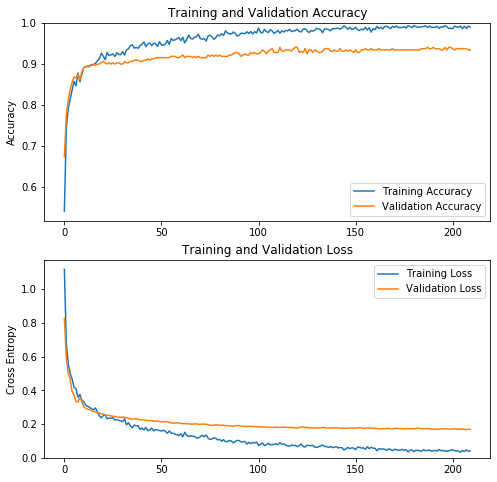

In [12]:
%matplotlib inline

# training and validation accuracy/loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if('history_fine' in globals()):
    acc += history_fine.history['acc']
    val_acc += history_fine.history['val_acc']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Plotting confusion matrix

Confusion Matrix
[[ 73   6   0   5]
 [  1  66   1   0]
 [  0   2 166   0]
 [  4   5   2  77]]
Classification Report
              precision    recall  f1-score   support

       glass       0.94      0.87      0.90        84
       metal       0.84      0.97      0.90        68
       paper       0.98      0.99      0.99       168
     plastic       0.94      0.88      0.91        88

    accuracy                           0.94       408
   macro avg       0.92      0.93      0.92       408
weighted avg       0.94      0.94      0.94       408

408/408 [==============================] - 3s 8ms/sample - loss: 0.2063 - acc: 0.9363
Accuracy: 93.6%
Loss: 20.6%


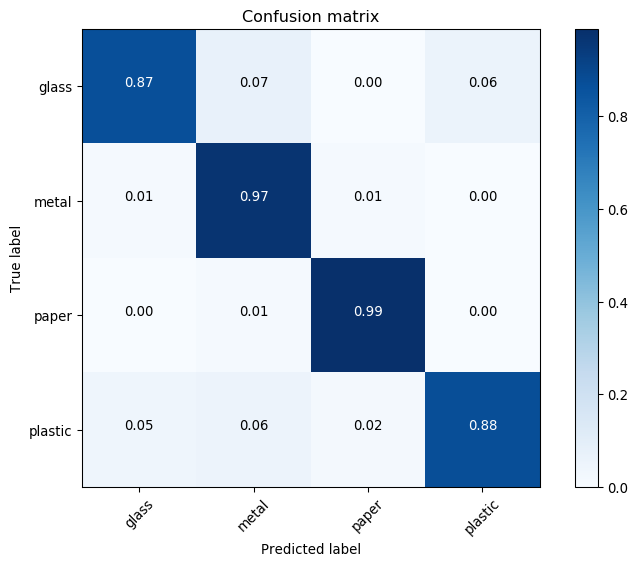

In [13]:
# confusion matrix
Y_pred = model.predict_generator(test_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=categories))

# evaluate keras model with model.evaluate()
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: {0:0.1f}%".format(acc * 100))
print("Loss: {0:0.1f}%".format(loss * 100))


plot_confusion_matrix(test_generator.classes, y_pred, categories)

In [18]:
from zipfile import ZipFile
from datetime import datetime
from subprocess import check_call

def save_notebook_html(name_notebook):
    notebook = name_notebook + ".ipynb"
    return check_call(['jupyter', 'nbconvert', '--to', 'html', notebook])

def notebook_identifier_name(name_notebook):
    return name_notebook + "_" + datetime.now().strftime("%H_%M_%d_%m_%Y")

def compress_model_notebook(name_notebook, model_file_path):
    if save_notebook_html(name_notebook) == 0:
        file = notebook_identifier_name(name_notebook)
        zip_folder = ZipFile(os.path.join("saved_model", file + ".zip"), 'w')
        zip_folder.write(name_notebook + ".html")
        zip_folder.write(model_file_path)
        zip_folder.close()

In [25]:
# save the model
name = notebook_identifier_name('CNN') + '.h5'
model.save(name)

In [26]:
compress_model_notebook('CNN', name)

##### Try to predict with model

In [ ]:
from tensorflow.keras.models import Model
categories = os.listdir('dataset\\v3')
loaded_model = keras.models.load_model('.\\saved_model\\best_densenet121_ft_v3_2019_07_30.h5')

In [ ]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'glass.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = x/255
x = preprocess_input(x)
plt.imshow(img)

In [ ]:
preds = model.predict_proba(x)
category = model.predict_classes(x)
print(preds)
print(categories[category.argmax()])